In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns

In [2]:
conn = psycopg2.connect(database="postgres",
                        host="pklmartdb.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [3]:
def pullawsdata(tablename):
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT column_name FROM information_schema.columns where table_name='{tablename}';")
            cols=cursor.fetchall()
            cols = [cols[x][0] for x in range(len(cols))]
            cursor.execute(f"SELECT * FROM pklm_prd.{tablename}")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cols))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [4]:
rally=pullawsdata('rally')

In [5]:
rally = rally[['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']]
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [6]:
game=pullawsdata('game')[['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']]
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '4'] = '4.0'
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [7]:
glist = list(rally.game_id.unique())
dlist = []
for i in range(len(glist)):
    gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
    to_list = []
    to_game = glist[i]
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]
            winpre = round(100*len(gi.iloc[pre][lambda x:x.w_team_id == toteam])/len(pre),1)
            winpost = round(100*len(gi.iloc[post][lambda x:x.w_team_id == toteam])/len(post),1)
            windelta = round(winpost-winpre,1)
            dlist.append([to_game,skill_lvl,j+1,toteam,rallynbr,winpre,winpost,windelta])

In [8]:
df_timeout = pd.DataFrame(dlist,columns=['game_id','skill_lvl','to_nbr','to_team','rally_nbr','prewin','postwin','deltawin'])

In [9]:
print('change in win percentage due to timeouts\n')
print(f'average: {round(df_timeout.deltawin.mean(),1)}')
print(f'median:  {df_timeout.deltawin.median()}')
print(f'maximum: {df_timeout.deltawin.max()}')
print(f'minimum: {df_timeout.deltawin.min()}')                                                      

change in win percentage due to timeouts

average: 5.6
median:  5.4
maximum: 60.0
minimum: -63.6


In [10]:
df_timeout.sort_values('deltawin').to_csv('timeout_momentum_sorted.csv',index=False)

In [11]:
df_wteam = game[['w_team_id','game_id']].groupby('w_team_id').count().reset_index(drop=False)
df_lteam = game[['l_team_id','game_id']].groupby('l_team_id').count().reset_index(drop=False)
df_wteam.columns=['team_id','won']
df_lteam.columns=['team_id','lost']
df_wl=df_wteam.merge(df_lteam,on='team_id',how='left')
df_lw=df_lteam.merge(df_wteam,on='team_id',how='left')
df_wnl = df_wl[df_wl.lost.notnull()]
df_w=df_wl[df_wl.lost.isnull()]
df_l=df_lw[df_lw.won.isnull()]
df_allres = pd.concat([pd.concat([df_wnl,df_w]),df_l]).fillna(0)
df_allres['GP'] = df_allres['won']+df_allres['lost']
df_allres[['won','lost','GP']] = df_allres[['won','lost','GP']].astype(int)
df_allres['team_id'] = [int(x[1:]) for x in df_allres.team_id]
df_allres = df_allres.sort_values('team_id')
df_allres.team_id = 'T'+df_allres.team_id.astype(str)
df_tobyteam = df_timeout[['to_team','game_id']].groupby('to_team').count().reset_index(drop=False)
df_tobyteam.columns = ['team_id','TO']
df_teammetrx = df_allres.merge(df_tobyteam,on='team_id',how='left')
df_teammetrx.TO = df_teammetrx['TO'].fillna(0).astype(int)
df_teammetrx['TOsPerGame'] = (df_teammetrx.TO/df_teammetrx.GP).round(2)
df_teamcalc = df_timeout[['to_team','deltawin']].groupby('to_team').mean().round(1).reset_index(drop=False)
df_teamcalc.columns=['team_id','avgDeltaWin']
df_teammetrx = df_teammetrx.merge(df_teamcalc,on='team_id',how='left')
df_teammetrx=df_teammetrx[['team_id', 'GP', 'TO', 'TOsPerGame', 'avgDeltaWin']]
df_teammetrx = df_teammetrx.sort_values('avgDeltaWin',ascending=False).merge(pullawsdata('team')[['team_id','team_nm']],on='team_id',how='left').drop_duplicates()
df_teammetrx.to_csv('team_timeout_data.csv',index=False)
print('team timeout data, sorted descending by average win % change:\n ')
df_teammetrx

team timeout data, sorted descending by average win % change:
 


,team_id,GP,TO,TOsPerGame,avgDeltaWin,team_nm
0,T9,2,1,0.50,60.0,Jesse Irvine & Anna Bright
2,T17,2,1,0.50,50.0,Ben Johns & Tyler Loong
4,T11,1,1,1.00,49.2,Chrissy Penfold & Eli Powell
6,T48,3,1,0.33,49.0,Monica Linn & Christian Keenum
8,T18,2,2,1.00,38.6,Collin Johns & AJ Koller
10,T16,1,1,1.00,36.7,Anna Bright & Jorja Johnson
12,T35,1,1,1.00,30.0,Jay Devilliers & Patrick Smith
14,T40,4,2,0.50,27.6,Ryan Kane & Brandon Ward
16,T13,4,2,0.50,26.1,Collin Johns & Ben Johns
18,T15,1,2,2.00,25.7,Vivienne David & Lauren Stratman


In [12]:
df_skill = game[['skill_lvl','game_id']].groupby('skill_lvl').count().round(1).reset_index(drop=False)
df_skill.columns=[['skill_lvl','num_games']]
df_skill['avg_delta_win'] = (df_timeout[['skill_lvl','deltawin']].groupby('skill_lvl').mean().round(1).reset_index(drop=False))['deltawin']
df_skill['pct_total'] = (100*df_skill.num_games/(df_skill.num_games.sum())).round(1)
df_skill[['skill_lvl','avg_delta_win','num_games','pct_total']].reset_index(drop=False)

,index,skill_lvl,avg_delta_win,num_games,pct_total
0,0,4.0,-6.2,3,4.3
1,1,4.5,-0.8,7,10.0
2,2,5.0,8.5,20,28.6
3,3,Pro,5.9,40,57.1


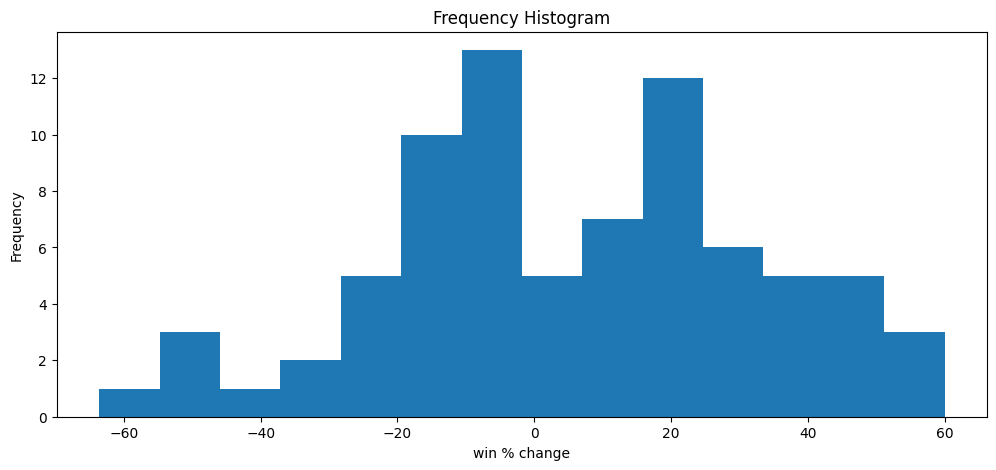

In [13]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin, bins=14)
plt.gca().set(title='Frequency Histogram', xlabel = 'win % change', ylabel='Frequency');

## Group plots by skill level

In [14]:
df_pro=df_timeout[df_timeout.skill_lvl == 'Pro']
df_40=df_timeout[df_timeout.skill_lvl == '4.0']
df_45=df_timeout[df_timeout.skill_lvl == '4.5']
df_50=df_timeout[df_timeout.skill_lvl == '5.0']
skilldata=[list(x.deltawin) for x in [df_40,df_45,df_50,df_pro,df_timeout]]

In [15]:
import numpy as np
np.linspace(1,5,5)

array([1., 2., 3., 4., 5.])

In [16]:
rally[rally.game_id == 55]

,game_id,rally_id,rally_nbr,srv_team_id,w_team_id,to_team_id
2369,55,2560,1,T44,T44,N/A
2370,55,2561,2,T44,T44,N/A
2371,55,2562,3,T44,T45,N/A
2372,55,2563,4,T45,T45,N/A
2373,55,2564,5,T45,T45,N/A
2374,55,2565,6,T45,T44,N/A
2375,55,2566,7,T45,T45,N/A
2376,55,2567,8,T45,T44,N/A
2377,55,2568,9,T44,T45,N/A
2378,55,2569,10,T44,T45,N/A


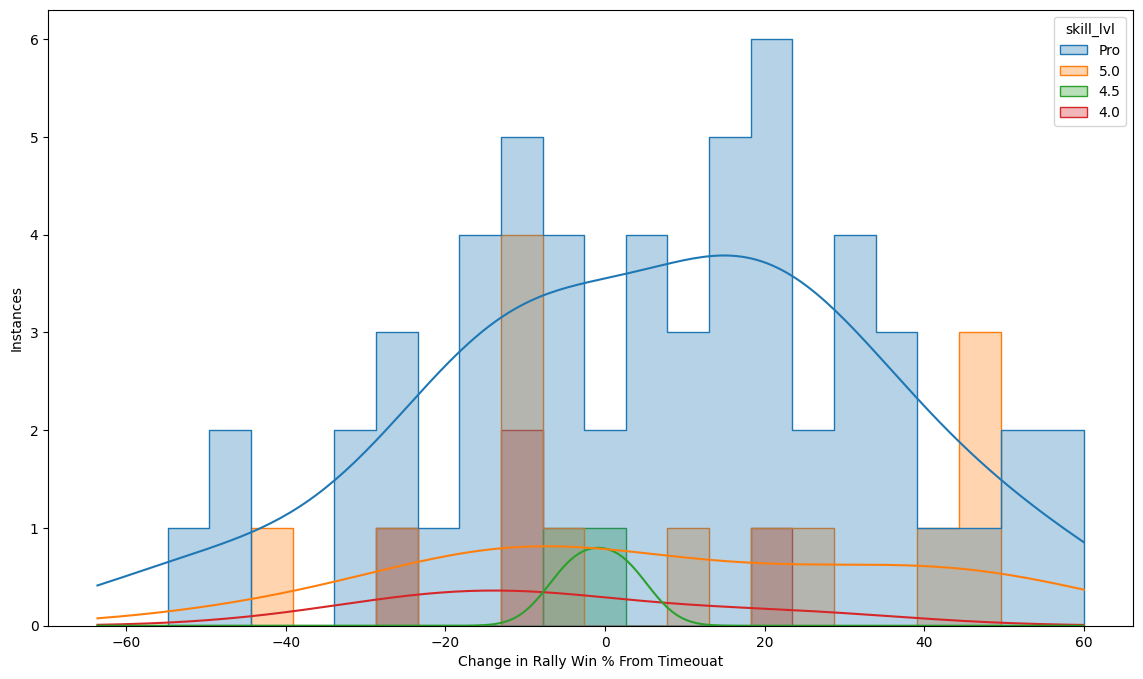

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-60, 60, 24)
p = sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Rally Win % From Timeouat",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

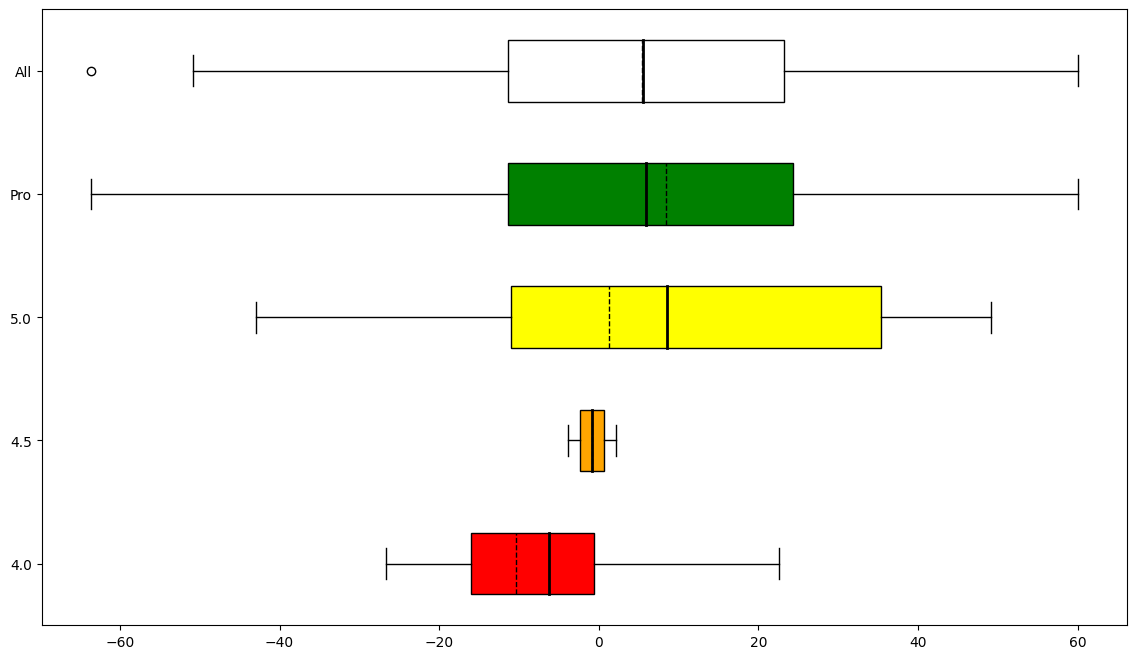

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')


box = plt.boxplot(skilldata,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['4.0','4.5','5.0','Pro','All'])

colors = ['red', 'orange', 'yellow', 'green', 'white']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

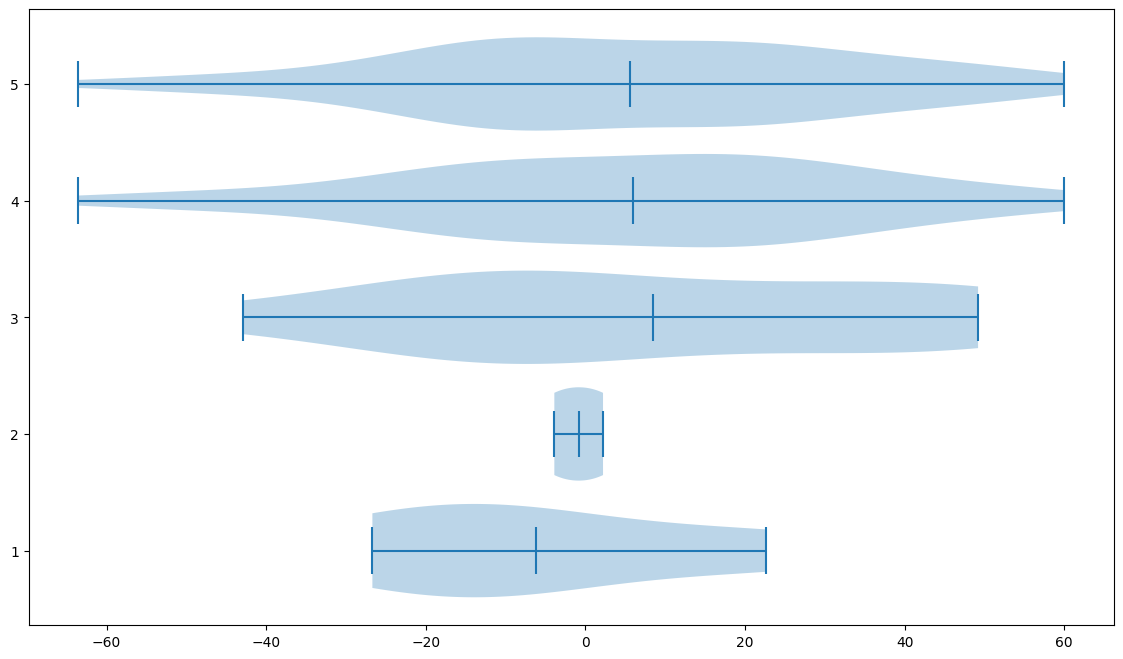

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))
vio=plt.violinplot(skilldata,vert=0,showextrema=True,showmeans=True,widths=.8)
plt.show()

## Repeat plots - but distinguishing between only 2 skill levels:  "Pro" and "Amateur"

In [20]:
df_timeout_bypro = df_timeout
df_timeout_bypro.skill_lvl.iloc[df_timeout_bypro.skill_lvl != 'Pro'] = 'Amateur'
df_pro=df_timeout_bypro[df_timeout_bypro.skill_lvl == 'Pro']
df_amtr=df_timeout_bypro[df_timeout_bypro.skill_lvl == 'Amateur']
skilldata=[list(x.deltawin) for x in [df_amtr,df_pro,df_timeout_bypro]]

In [29]:
df_timeout_bypro.sort_values('deltawin').head(10)

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,prewin,postwin,deltawin
43,28,Pro,2,T25,49,63.6,0.0,-63.6
39,23,Pro,2,T21,68,50.9,0.0,-50.9
45,30,Pro,1,T25,20,47.4,0.0,-47.4
21,12,Pro,1,T6,40,46.2,0.0,-46.2
53,38,Amateur,2,T38,45,42.9,0.0,-42.9
72,58,Pro,2,T46,40,33.3,0.0,-33.3
3,1,Pro,4,T1,61,30.0,0.0,-30.0
77,74,Amateur,1,T58,16,26.7,0.0,-26.7
11,5,Pro,1,T3,27,46.2,20.0,-26.2
27,16,Pro,1,T4,39,50.0,25.0,-25.0


In [31]:
df_timeout_bypro.sort_values('deltawin').tail(20)

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,prewin,postwin,deltawin
59,47,Amateur,1,T41,38,43.2,66.7,23.5
64,52,Pro,1,T5,27,46.2,71.4,25.2
0,1,Pro,1,T1,22,38.1,64.3,26.2
48,35,Pro,1,T35,51,50.0,80.0,30.0
23,14,Pro,1,T8,11,20.0,50.0,30.0
30,19,Pro,1,T15,24,39.1,70.0,30.9
65,52,Pro,2,T13,35,28.6,61.5,32.9
2,1,Pro,3,T2,50,33.3,70.0,36.7
31,19,Pro,2,T16,35,30.0,66.7,36.7
49,35,Pro,2,T34,57,20.0,57.1,37.1


In [34]:
rally[rally.game_id == 28]

,game_id,rally_id,rally_nbr,srv_team_id,w_team_id,to_team_id
1284,28,1328,1,T25,T26,N/A
1285,28,1329,2,T26,T25,N/A
1286,28,1330,3,T26,T25,N/A
1287,28,1331,4,T25,T26,N/A
1288,28,1332,5,T25,T26,N/A
1289,28,1333,6,T26,T25,N/A
1290,28,1334,7,T26,T25,N/A
1291,28,1335,8,T25,T26,N/A
1292,28,1336,9,T25,T26,N/A
1293,28,1337,10,T26,T26,N/A


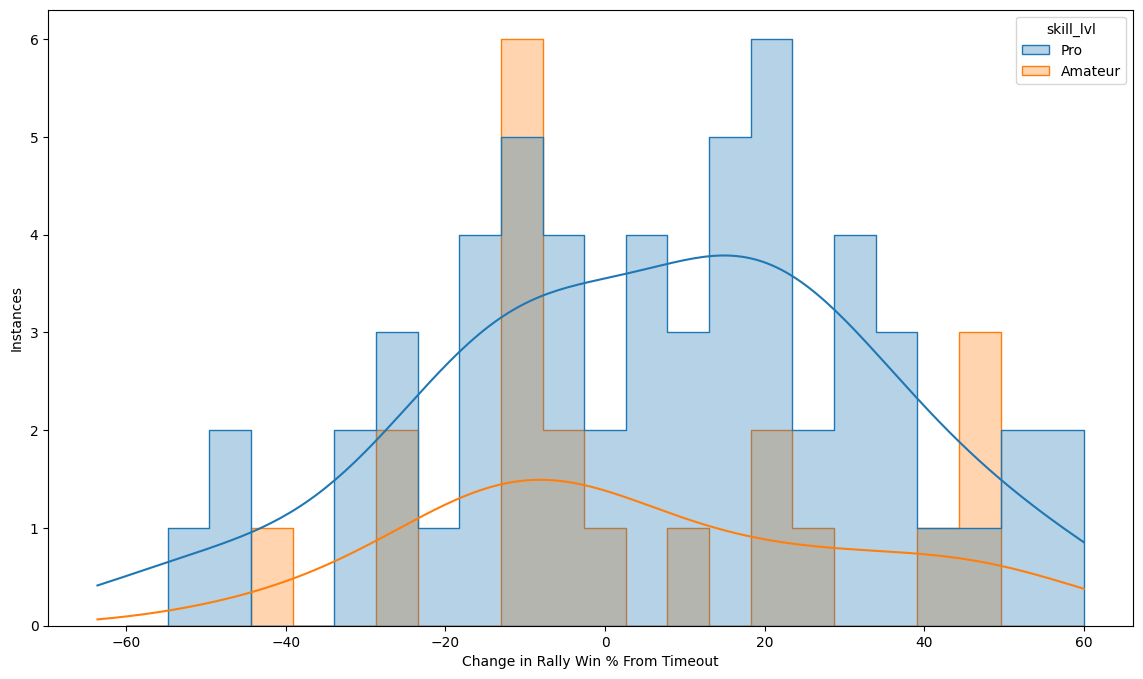

In [21]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-60, 60, 24)
p=sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

mean = solid line, median = dashed line


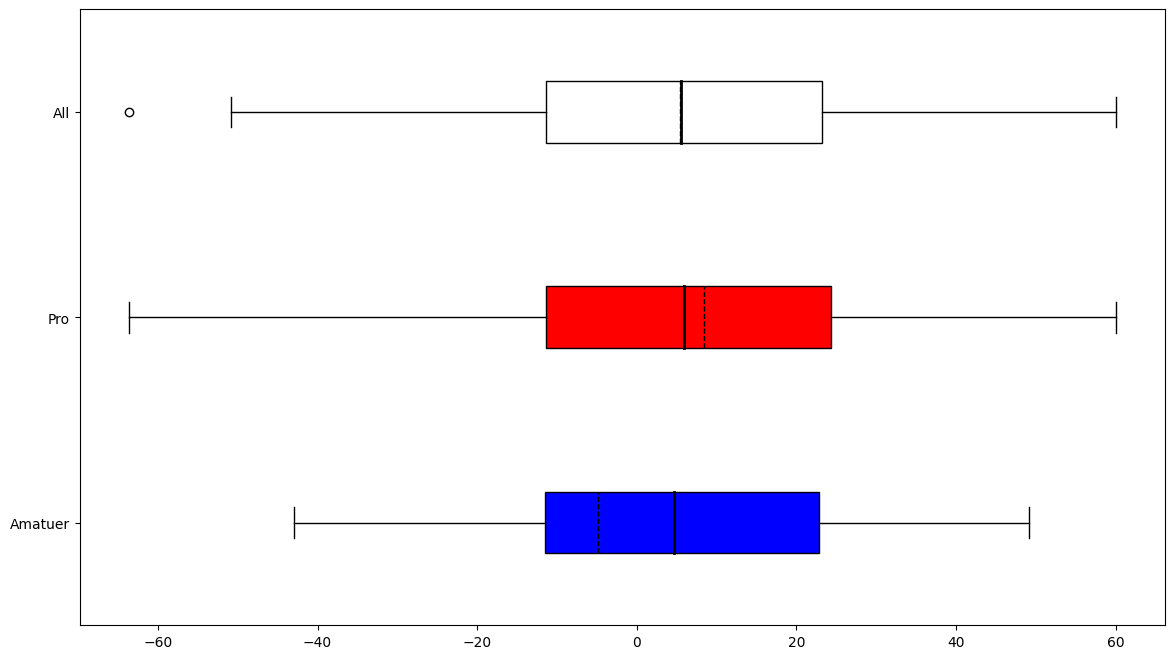

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')


box = plt.boxplot(skilldata,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['Amatuer','Pro','All'])

colors = ['blue', 'red', 'white']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
print('mean = solid line, median = dashed line')
plt.show()

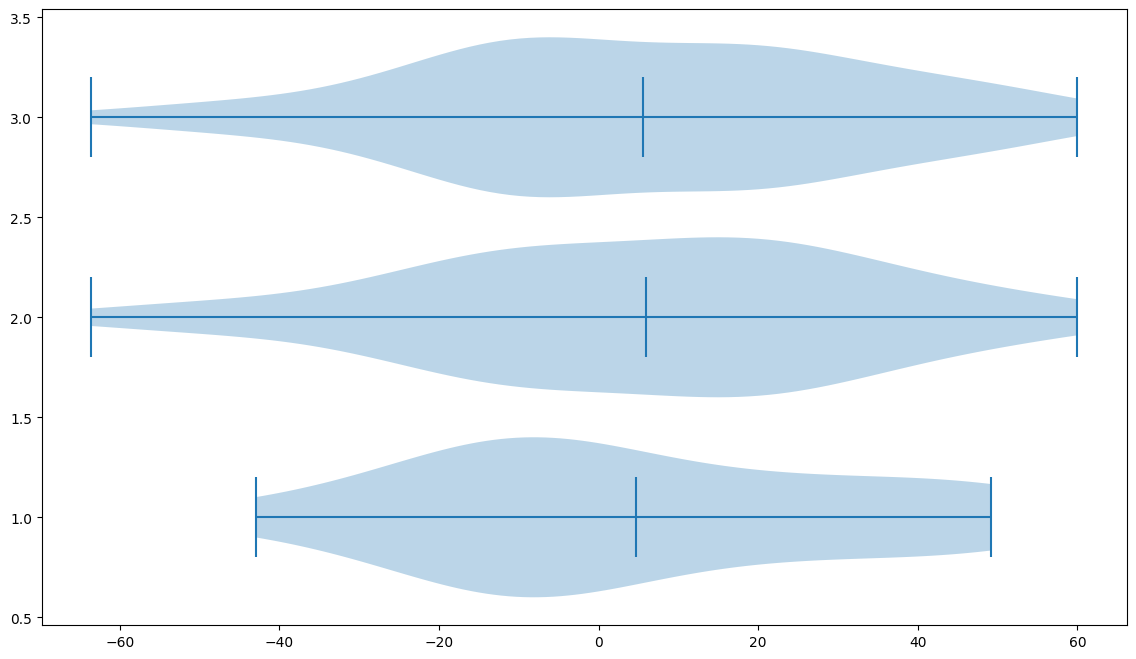

In [23]:
fig, ax = plt.subplots(figsize=(14, 8))
vio=plt.violinplot(skilldata,vert=0,showextrema=True,showmeans=True,widths=.8)
plt.show()